## RETOUCH analysis

In [1]:
import keras

Using TensorFlow backend.


### Model architecture

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(4,(4,4),padding='same',strides=(2,2),input_shape=(1024,512,1),use_bias=True))
model.add(keras.layers.Conv2DTranspose(4,(4,4),padding='same',strides=(2,2),use_bias=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 512, 256, 4)       68        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 1024, 512, 4)      260       
Total params: 328.0
Trainable params: 328
Non-trainable params: 0.0
_________________________________________________________________


### Loss function

#### Note
0 is background; 1 is intraretinal fluid; 2 is subretinal fluid; and 3 is pigment epithelial detachment

In [56]:
def loss(y, yhat):
    return -(np.log(yhat) * y).sum()


In [60]:
loss(np.array([[[0,1],[1,0]],[[0,1],[1,0]]]),np.array([[[.1,.9],[.8,.2]],[[.1,.9],[.8,.2]]]))

0.65700813394407198

In [61]:
2*(-np.log(.9)-np.log(.8))

0.65700813394407198

In [2]:
import SimpleITK as sitk

#### Cirrus data

In [3]:
cirrus_sample_oct = sitk.ReadImage('../Cirrus_part1/5fef2f4c2adcda3b9e07801f713d4ccf/oct.mhd')
cirrus_sample_ref = sitk.ReadImage('../Cirrus_part1/5fef2f4c2adcda3b9e07801f713d4ccf/reference.mhd')

In [12]:
cirrus_sample_oct_arr = sitk.GetArrayFromImage(cirrus_sample_oct)
cirrus_sample_ref_arr = sitk.GetArrayFromImage(cirrus_sample_ref)

In [13]:
cirrus_sample_oct_arr.dtype, cirrus_sample_ref_arr.dtype

(dtype('uint8'), dtype('uint8'))

In [14]:
cirrus_sample_oct_arr.shape, cirrus_sample_ref_arr.shape

((128, 1024, 512), (128, 1024, 512))

In [17]:
import numpy as np
np.unique(cirrus_sample_ref_arr)

array([0, 2, 3], dtype=uint8)

In [23]:
# One-hot encoding the mask
one_h = np.zeros([128,1024,512,4])
for i in range(128):
    for j in range(1024):
        for k in range(512):
            one_h[i,j,k,cirrus_sample_ref_arr[i,j,k]]=1


(26, array([ 1.,  0.,  0.,  0.]))

In [30]:
cirrus_sample_ref_arr[59,300,300],one_h[59,300,300]

(3, array([ 0.,  0.,  0.,  1.]))

In [64]:
one_h1 = keras.utils.to_categorical(cirrus_sample_ref_arr) # Out of memory

MemoryError: 

In [66]:
1200*12*2

28800

In [41]:
-(np.log(one_h + .01) * one_h).sum()

MemoryError: 

In [43]:
np.unique(cirrus_sample_ref_arr,return_counts=True)

(array([0, 2, 3], dtype=uint8),
 array([66362571,    61827,   684466], dtype=int64))

In [50]:
np.array([66362571,    61827,   684466])*100./1024/512/128

array([  9.88879368e+01,   9.21294093e-02,   1.01993382e+00])

#### Spectralis data

In [6]:
spectralis_sample_oct = sitk.ReadImage('../Spectralis_part1/83e7b9339019b549c87830f90c560fea/oct.mhd')
spectralis_sample_ref = sitk.ReadImage('../Spectralis_part1/83e7b9339019b549c87830f90c560fea/reference.mhd')

In [7]:
spectralis_sample_oct_arr = sitk.GetArrayFromImage(spectralis_sample_oct)
spectralis_sample_ref_arr = sitk.GetArrayFromImage(spectralis_sample_ref)

In [8]:
spectralis_sample_oct_arr.dtype, spectralis_sample_ref_arr.dtype

(dtype('uint16'), dtype('uint8'))

In [9]:
spectralis_sample_oct_arr.shape, spectralis_sample_ref_arr.shape

((49, 496, 512), (49, 496, 512))

### Visual

In [10]:
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

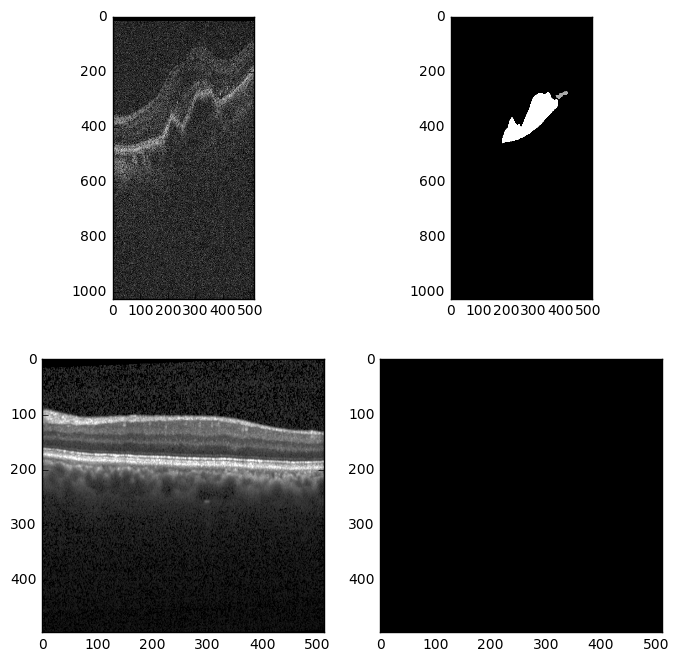

In [28]:
n1=59
n2=33
fig,ax = plt.subplots(2,2,figsize=[8,8])
ax[0,0].imshow(cirrus_sample_oct_arr[n1],cmap='gray')
ax[0,1].imshow(cirrus_sample_ref_arr[n1],cmap='gray')
ax[1,0].imshow(spectralis_sample_oct_arr[n2],cmap='gray')
ax[1,1].imshow(spectralis_sample_ref_arr[n2],cmap='gray')

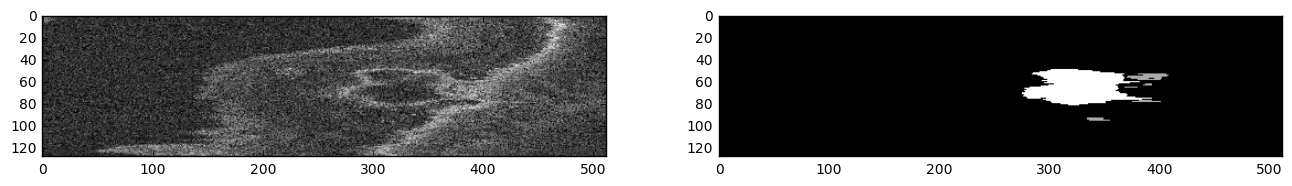

In [13]:
j = 300
fig,ax = plt.subplots(1,2,figsize=[16,16])
ax[0].imshow(cirrus_sample_oct_arr[:,j,:],cmap='gray')
ax[1].imshow(cirrus_sample_ref_arr[:,j,:],cmap='gray')

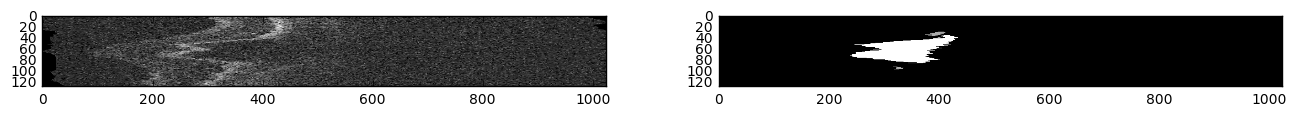

In [14]:
j = 309
fig,ax = plt.subplots(1,2,figsize=[16,16])
ax[0].imshow(cirrus_sample_oct_arr[:,:,j],cmap='gray')
ax[1].imshow(cirrus_sample_ref_arr[:,:,j],cmap='gray')

In [15]:
# exercise cell
import tensorflow as tf
tf.__version__

'1.0.1'

In [16]:
from keras import backend as K

Using TensorFlow backend.


In [17]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [18]:
from keras.optimizers import SGD

In [19]:
from keras.models import Model
from keras.layers import Input,Convolution2D,MaxPooling2D
inputs = Input((1024, 512,1))
conv1 = Convolution2D(32, (3, 3), activation='relu', border_mode='same')(inputs)
conv1 = Convolution2D(32, (3, 3), activation='relu', border_mode='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

model = Model(input=inputs, output=pool1)
model.compile(optimizer=SGD(lr=1.0e-2), loss=dice_coef_loss, metrics=[dice_coef])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=Tensor("in...)`


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 512, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 512, 32)     320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 512, 32)     9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 256, 32)      0         
Total params: 9,568.0
Trainable params: 9,568.0
Non-trainable params: 0.0
_________________________________________________________________


In [21]:
(32*3*3+1)*32 # Verify the number of parameters in the 2nd conv2d

9248

In [22]:
import tensorflow as tf

In [23]:
layer = tf.placeholder(tf.float32,[None,32,32,1])

In [24]:
W=tf.Variable(tf.random_normal([4,4,5,1]),tf.float32)

In [25]:
layer.get_shape()

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(1)])

In [26]:
W.get_shape()

TensorShape([Dimension(4), Dimension(4), Dimension(5), Dimension(1)])

In [27]:
tf.nn.conv2d_transpose(layer,W,[5,64,64,5],[1,2,2,1],padding='SAME')

<tf.Tensor 'conv2d_transpose:0' shape=(5, 64, 64, 5) dtype=float32>

In [70]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(2,(4,4),padding='valid',strides=(2,2),input_shape=(129,129,1),use_bias=False))

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 63, 63, 2)         32        
Total params: 32.0
Trainable params: 32
Non-trainable params: 0.0
_________________________________________________________________


In [72]:
model.add(keras.layers.Conv2DTranspose(1,(2,2),padding='same',strides=(2,2),use_bias=True))

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 63, 63, 2)         32        
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 126, 126, 1)       9         
Total params: 41.0
Trainable params: 41
Non-trainable params: 0.0
_________________________________________________________________
